![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 24 - Time Series Analysis</center>
### <center> SARIMA </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/24_TimeSeries/MainSARIMA.ipynb)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#### Just a plot function:

In [2]:
from scipy.stats                   import gaussian_kde, norm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic  import acorr_ljungbox

def PlotResidual(En, fig):
    std     = np.std(En)
    kde     = gaussian_kde(En)
    _, pVal = acorr_ljungbox(En, [40], return_df=False)
    pVal    = pVal[-1]

    ax = fig.add_subplot(2,1,1)
    x  = np.arange(len(En))
    ax.stem(x, En, use_line_collection=True, label='$e_n$')
    ax.hlines(0, x[0], x[-1], alpha = 0.5)
    ax.set_xlim( x[0], x[-1])
    ax.set_title('$\mu_e = ' + "%1.3f" % np.mean(En) + '$, $\sigma_e = ' + "%1.3f" % std + '$')
    plt.xlabel('$n$')
    plt.legend()

    ax   = fig.add_subplot(2,2,3)
    xlim = (-3*std, 3*std)
    x    = np.linspace(xlim[0], xlim[1])
    ax.hist(En, density=True, color='c', edgecolor='k', label='Hist')
    ax.plot(x, kde(x),                                  label='KDE')
    ax.plot(x, norm.pdf(x, 0, std),                     label='$\mathcal{N}(0,\sigma^2)$')
    ax.set_xlim(xlim)
    ax.legend()
    ax.set_title('Density estimation')

    ax = fig.add_subplot(2,2,4)
    plot_acf(En, ax=ax, lags = 20, adjusted=True, label='$\hat{\\rho}_{e}[k]$')
    ax.set_title('white noise test: $p = ' + '%1.5f' % pVal + '$')
    plt.xlabel('$k$')
    plt.legend()

    plt.tight_layout()

    return fig

### Load data:

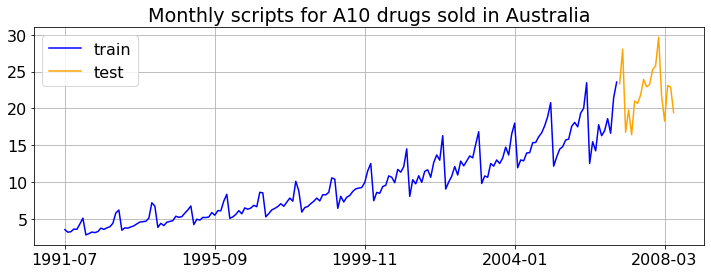

In [3]:
dData = pd.read_csv('./a10.csv')
vX    = dData.x.values
Dates = np.arange('1991-07', '2008-07', dtype='datetime64[M]')
N     = len(vX)

vIdx    = np.arange(N)
Ntrain  = 185
vTrainX = vX[:Ntrain]
vTestX  = vX[Ntrain:]

#-- Plotting data
plt.figure(figsize=(12, 4)); plt.grid(True)
plt.plot(vIdx[:Ntrain], vTrainX, 'b',      label='train')
plt.plot(vIdx[Ntrain:], vTestX,  'orange', label='test')
plt.legend(loc='upper left')
plt.title('Monthly scripts for A10 drugs sold in Australia')
plt.xticks(vIdx[::50], Dates[::50])
plt.show()

### Apply $\log(\cdot)$ to adjust variance:

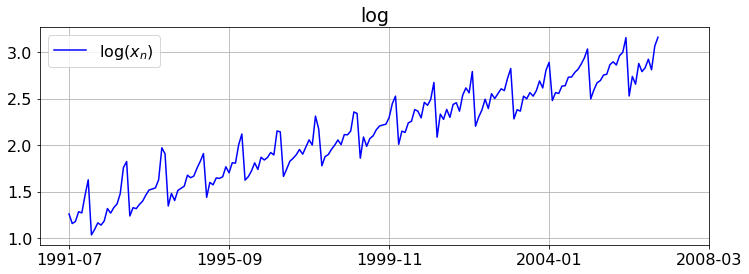

In [4]:
vLogTrainX = np.log(vTrainX)

#-- Plotting data
plt.figure(figsize=(12, 4)); plt.grid(True)
plt.plot(vIdx[:Ntrain], vLogTrainX, 'b', label='$\log(x_n)$')
plt.legend(loc = 2)
plt.title('log')
plt.xticks(vIdx[::50], Dates[::50])
plt.show()

### Plot ACF and PACF:

C:\Users\Or\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


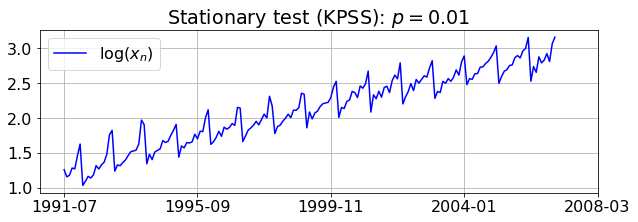

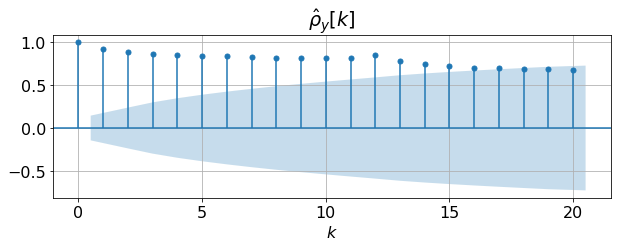

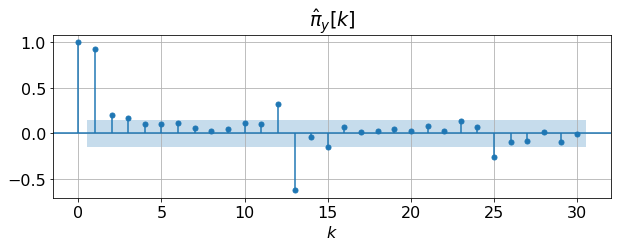

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools     import kpss

pVal = kpss(vLogTrainX, nlags='auto')[1]

#-- Plotting data
plt.figure(figsize=(10, 3)); plt.grid(True)
plt.plot(vIdx[:Ntrain], vLogTrainX, 'b', label='$\log(x_n)$')
plt.legend(loc = 2)
plt.title(f'Stationary test (KPSS): $p = {pVal}$')
plt.xticks(vIdx[::50], Dates[::50])

#-- ACF & PACF
_, ax = plt.subplots(1, 1, figsize=(10, 3)); plt.grid(True)
plot_acf(vLogTrainX, lags=20, adjusted=True, ax=ax)
plt.title('$\hat{\\rho}_y[k]$')
plt.xlabel('$k$')

_, ax = plt.subplots(1, 1, figsize=(10, 3)); plt.grid(True)
plot_pacf(vLogTrainX, lags=30, ax=ax)
plt.title('$\hat{\pi}_y[k]$')
plt.xlabel('$k$')
plt.show()

### Seasonal differencing ($S=12$):
$$\tilde{X}_{n}=X_{n}-X_{n-S}$$

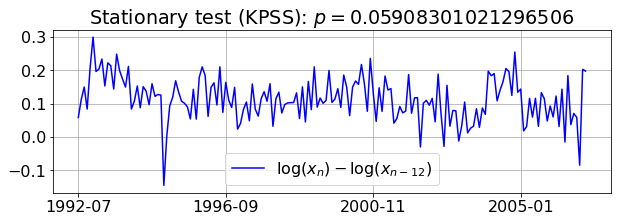

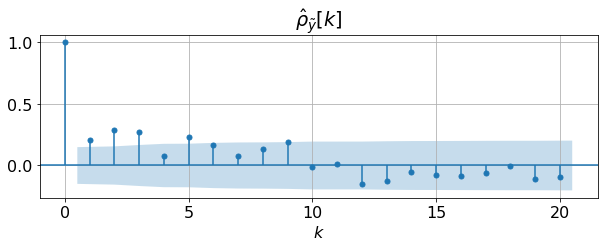

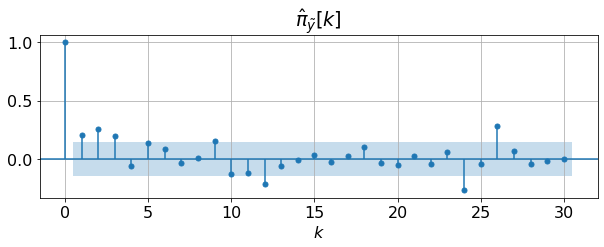

In [6]:
S      = 12
vDlogX = vLogTrainX[S:] - vLogTrainX[:-S]
pVal   = kpss(vDlogX, nlags='auto')[1]

#-- Plotting data
plt.figure(figsize=(10, 3)); plt.grid(True)
plt.plot(vIdx[S:Ntrain], vDlogX, 'b', label=r'$\log\left(x_{n}\right)-\log\left(x_{n-12}\right)$')
plt.legend()
plt.title(f'Stationary test (KPSS): $p = {pVal}$')
plt.xticks(np.arange(S, N, 50), Dates[S::50])
plt.show()

#-- ACF & PACF
_, ax = plt.subplots(1, 1, figsize=(10, 3)); plt.grid(True)
plot_acf(vDlogX, lags=20, adjusted=True, ax=ax)
plt.title('$\hat{\\rho}_{\\tilde{y}}[k]$')
plt.xlabel('$k$')

_, ax = plt.subplots(1, 1, figsize=(10, 3)); plt.grid(True)
plot_pacf(vDlogX, lags=30, ax=ax)
plt.title('$\hat{\pi}_{\\tilde{y}}[k]$')
plt.xlabel('$k$')
plt.show()

### Train multiple SARIMA models (and choose the best one):
$S$, $d$, and $D$ need to be set manually

In [8]:
from statsmodels.tsa.statespace import sarimax

vp = np.arange(3)
vq = np.arange(3)
vP = np.arange(3)
vQ = np.arange(3)

d  = 0
D  = 1

T  = pd.DataFrame(columns=['p', 'q', 'P', 'Q', 'AIC', 'BIC'])
for pp in vP:
    for qq in vQ:
        for PP in vP:
            for QQ in vQ:
                oModel        = sarimax.SARIMAX(vLogTrainX, order=(pp,d,qq), seasonal_order=(PP,D,QQ,S), trend='c').fit(maxiter=100)
                T.loc[len(T)] = [pp, qq, PP, QQ, oModel.aic, oModel.bic] 

T.sort_values(by='AIC')

C:\Users\Or\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Or\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Or\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Or\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Or\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood op

,p,q,P,Q,AIC,BIC
65,2.0,1.0,0.0,2.0,-498.187044,-476.114003
47,1.0,2.0,0.0,2.0,-497.394363,-475.321322
38,1.0,1.0,0.0,2.0,-496.365966,-477.446217
56,2.0,0.0,0.0,2.0,-495.466919,-476.547170
68,2.0,1.0,1.0,2.0,-495.155198,-469.928865
...,...,...,...,...,...,...
17,0.0,1.0,2.0,2.0,-444.591191,-422.518150
8,0.0,0.0,2.0,2.0,-440.629753,-421.710004
35,1.0,0.0,2.0,2.0,-440.575536,-418.502495
25,0.0,2.0,2.0,1.0,-359.386201,-337.313160


### Training a single SARIMA model:

In [ ]:
#-- SARIMA(p,d,q)(P,D,Q,S) with constnat model:
p = 2
q = 1
P = 0
Q = 2
oTrainModel = sarimax.SARIMAX(vLogTrainX,
                              order          = (p,d,q),
                              seasonal_order = (P,D,Q,12),
                              trend          = 'c').fit(maxiter=1000)
oTrainModel.summary()

### Plot error (residual) statistics:

In [ ]:
#-- One step prediction (train set):
start = 25
oPred = oTrainModel.get_prediction(start=start, end=Ntrain-1, dynamic=False)

#-- Residuals:
En    = vLogTrainX[start:] - oPred.predicted_mean

fig = plt.figure(figsize=(12, 8))
PlotResidual(En, fig)
plt.show()

### Predict (forecast):
train, test (one step), and long test (future forecast)

In [ ]:
#-- Add test data to the model:
oTestModel = sarimax.SARIMAX(np.log(vX), order=(p,d,q), seasonal_order=(P,D,Q,S), trend='c')
oTestModel = oTestModel.filter(oTrainModel.params)

#-- One step prediction (train), Dynamic forecast (test):
Np    = 20
oPred = oModel.get_prediction(start, N - 1 + Np, Ntrain - start)
vHatX = oPred.predicted_mean

#-- Confidence intervals, alpha = 0.05 (95%):
pred_ci = oPred.conf_int(alpha=0.05)

#-- Inverse log (exp):
vHatX        = np.exp(vHatX)
pred_ci[:,0] = np.exp(pred_ci[:,0])
pred_ci[:,1] = np.exp(pred_ci[:,1])

#-- Plot:
vPredIdx = np.arange(start, N + Np)
plt.figure(figsize=(16, 5)); plt.grid(True)
plt.plot(vIdx[:Ntrain], vTrainX, 'b',     lw=1.5, label='train')
plt.plot(vIdx[Ntrain:], vTestX,  'orange',lw=1.5, label='test')
plt.plot(vPredIdx,      vHatX,   'r',     lw=1.5, label='$\hat{x}_n$')
plt.fill_between(vPredIdx, pred_ci[:,0], pred_ci[:,1],
                 color='r', alpha=.15, label = '95% CI')
plt.legend(loc='upper left')
plt.title('SARIMA($p=%d,d=%d,q=%d$)($P=%d,D=%d,Q=%d)_{%d}$ forecast' % (p,d,q,P,D,Q,S))
plt.xticks(vIdx[6::12], Dates[6::12])
plt.xlim([N/2, N+Np])
plt.show()